In [11]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon, ranksums
import statsmodels.api as sm
pd.options.display.max_columns = 99
import statsmodels.formula.api as smf
import math 
import scipy.stats as ss
plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
datadir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSM'
datadir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Presentations/2016_06_ESSTS_QSM'

measures = [ #'Age','SNR' , 'CNR' , 'FBER',  'QI1', 
            # 'R_Caud', 'L_Caud', 'R_Puta', 'L_Puta', 'R_Pall', 'L_Pall',
            # 'R_Amyg', 'L_Amyg', 'R_Hipp', 'L_Hipp', 'R_Accu', 'L_Accu',
            # 'R_Thal', 'L_Thal', 'L_Insula', 'R_Insula', 'L_Cingulum', 'R_Cingulum', 
            # 'L_ant_Insula', 'R_ant_Insula', 'L_inf_Insula', 'R_inf_Insula',  'L_sup_Insula', 'R_sup_Insula', 
            # 'L_ant_Cingulum', 'R_ant_Cingulum', 'L_ant_mid_Cingulum', 'R_ant_mid_Cingulum',
            # 'L_post_mid_Cingulum', 'R_post_mid_Cingulum', 'L_post_dors_Cingulum',
            # 'R_post_dors_Cingulum','L_post_vent_Cingulum', 'R_post_vent_Cingulum', 
            # 'L_RN', 'R_RN', 'L_STN', 'R_STN', 'L_SN', 'R_SN',
             'Caud', 'Puta', 'Pall', 'Thal', 'Accu',# 'Amyg', 'Hipp', 
             'RN', 'SN','STN',
             'Insula', #'ant_Insula', 'inf_Insula', 'sup_Insula',
             'Cingulum',# 'post_mid_Cingulum', 'post_dors_Cingulum','post_vent_Cingulum', 'ant_Cingulum', 'ant_mid_Cingulum'
            'BrainStem', 'BasalGanglia'
            ]

drop_c =  []
drop_p = ['NL2P', 'STDP', 'HSPP', 'CB4P', 'SA5U']     #drop = ['CB4P', 'NL2P', 'YU1P', 'LA9P']


In [12]:
def plot(df1,df2,measure):
    palette = sns.xkcd_palette([ "red", 'blue'])
    data = [df1[measure], df2[measure]]
    sns.violinplot(data=data, palette= palette)
    sns.stripplot(data=data,palette= palette, jitter=1)

    
def detect_outliers(df, measure):
    mu = np.mean(df[measure])
    sd = np.std(df[measure])
    thresh = 3
    upper = mu +thresh*sd
    lower = mu -thresh*sd
    outliers = []
    for subject in df.index:
        i = df.loc[subject][measure]
        if i > upper or i < lower:
            outliers.append(subject)
            df.ix[subject, measure] = np.nan
            print outliers
            print 'OUTLIER: %s %s= %s, Limits= (%s,%s)'%(subject, measure, i, lower, upper)
    
    return outliers

def plot_partial_correlation(data, x, y,  regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df)#, size=size, ratio=ratio, space=space, #xlim=xlim, ylim=ylim), xlim=xlim, ylim=ylim
    grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, color = color, x_partial = df[regressors], y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
        
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
                      
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)

df1 = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)
df2 = pd.read_csv(os.path.join(datadir, 'patients_a.csv'), index_col = 0)

In [13]:
def make_ttest():
    df1 = pd.read_csv(os.path.join(datadir, 'controls_a_DICOM.csv'), index_col = 0)# * 100
    df2 = pd.read_csv(os.path.join(datadir, 'patients_a_DICOM.csv'), index_col = 0)# * 100
    
    df = pd.DataFrame(index= ['Controls', 'Patients', 'Z', 'p_val',], columns=measures)
    for measure in measures:
        #drop_c = detect_outliers(df1, measure)
        #drop_p = detect_outliers(df2, measure)
        t_val, p_val = mannwhitneyu(df1[measure], df2[measure].drop(drop_p, axis = 0))
        #t_val, p_val = ttest_ind(df1[measure], df2[measure].drop(drop_p, axis = 0))
        x = 100
        df.ix['Controls'][measure] = '%s±%s'%(x*np.round(np.mean(df1[measure]),4), 
                                              x*np.round(np.std(df1[measure]),4))     
        df.ix['Patients'][measure] = '%s±%s'%(x*np.round(np.mean(df2[measure].drop(drop_p, axis = 0)),4), 
                                              x*np.round(np.std(df2[measure].drop(drop_p, axis = 0)),4))   
        df.ix['Z'][measure] = np.round(t_val,2)        
        df.ix['p_val'][measure] = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
        
    return df.T
x = make_ttest()
x.sort(columns='p_val')

BasalGanglia p = 0.043


,Controls,Patients,Z,p_val
BasalGanglia,2.32±1.34,1.62±1.01,143,0.04341
SN,10.33±3.88,8.82±2.67,147,0.05393
Caud,2.39±1.6,1.66±1.01,150,0.06308
Puta,0.92±1.73,0.13±1.37,154,0.0771
BrainStem,5.64±3.46,4.51±2.5,154,0.0771
RN,6.55±4.72,4.87±4.09,167,0.13896
Pall,7.55±2.04,6.82±2.68,184,0.26091
Accu,-1.59±2.27,-2.12±2.28,185,0.26948
Insula,-2.33±1.54,-2.19±1.32,197,0.38184
STN,0.03±4.26,-0.17±2.96,201,0.42227


In [14]:
pd.DataFrame(x.p_val).sort(columns='p_val')

,p_val
BasalGanglia,0.04341
SN,0.05393
Caud,0.06308
Puta,0.0771
BrainStem,0.0771
RN,0.13896
Pall,0.26091
Accu,0.26948
Insula,0.38184
STN,0.42227


In [33]:
def make_fdr(df):
    fdr = pd.DataFrame()
    for i in df.index:
        for c in df.columns:
            fdr.ix['%s_%s'%(i,c),'p'] = df.loc[i][c]
    fdr = fdr.dropna()
    fdr = fdr.sort('p')
    
    n_comparisons = len(fdr.index)
    for i, corr in enumerate(fdr.index):
        fdr.ix[corr, 'FDR_threshold'] = np.round((0.05 * (i + 1.) / n_comparisons), 3)
        
    return fdr.reindex()

make_fdr(pd.DataFrame(x.p_val))

,p,FDR_threshold
BasalGanglia_p_val,0.04341,0.004
SN_p_val,0.05393,0.008
Caud_p_val,0.06308,0.013
Puta_p_val,0.07710,0.017
BrainStem_p_val,0.07710,0.021
RN_p_val,0.13896,0.025
Pall_p_val,0.26091,0.029
Accu_p_val,0.26948,0.033
Insula_p_val,0.38184,0.038
STN_p_val,0.42227,0.042


In [34]:
controls_a = pd.read_csv(os.path.join(datadir, 'controls_a_DICOM.csv'), index_col = 0)
patients_a = pd.read_csv(os.path.join(datadir, 'patients_a_DICOM.csv'), index_col = 0)

In [35]:
def get_clinical(df, pop_name):
    clinical_df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s.csv'%pop_name), index_col=0)
    
    for subject in df.index:
        if subject in clinical_df.index:
            df.ix[subject, 'YGTSS']             = clinical_df.loc[subject]['YGTSS_Total_Tic_Score']
            df.ix[subject, 'RVTRS']             = clinical_df.loc[subject]['RVTRS']
            df.ix[subject, 'PUTS']              = clinical_df.loc[subject]['puts']
            df.ix[subject, 'YBOCS']             = clinical_df.loc[subject]['YBOCS_Totalscore_Items_1to10']
            df.ix[subject, 'OCI']               = clinical_df.loc[subject]['OCIR_total score']
            df.ix[subject, 'CAARS' ]            = clinical_df.loc[subject]['CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score']
            df.ix[subject, 'DSM4']              = clinical_df.loc[subject]['DSM4_clinically_significant_ADHD']
            df.ix[subject, 'QOL']               = clinical_df.loc[subject]['qol_scale']
            df.ix[subject, 'QOLs']              = clinical_df.loc[subject]['qol_score']
            df.ix[subject, 'BDI']               = clinical_df.loc[subject]['BDI12']
            df.ix[subject, 'Ferritin']          = clinical_df.loc[subject]['Ferritin']
    
    return df, clinical_df

In [36]:
Xcontrols_a, controls_a_clinical = get_clinical(controls_a, 'controls_a')
Xpatients_a, patients_a_clinical = get_clinical(patients_a, 'patients_a')

In [37]:
Xpatients_a

,Age,Gender,SNR,CNR,FBER,QI1,R_Caud,L_Caud,R_Puta,L_Puta,R_Pall,L_Pall,R_Amyg,L_Amyg,R_Hipp,L_Hipp,R_Accu,L_Accu,R_Thal,L_Thal,L_ant_Insula,R_ant_Insula,L_inf_Insula,R_inf_Insula,L_sup_Insula,R_sup_Insula,L_Insula,R_Insula,L_ant_Cingulum,R_ant_Cingulum,L_ant_mid_Cingulum,R_ant_mid_Cingulum,L_post_mid_Cingulum,R_post_mid_Cingulum,L_post_dors_Cingulum,R_post_dors_Cingulum,L_post_vent_Cingulum,R_post_vent_Cingulum,L_Cingulum,R_Cingulum,L_RN,R_RN,L_STN,R_STN,L_SN,R_SN,Caud,Puta,Pall,Amyg,Hipp,Accu,Thal,ant_Insula,sup_Insula,inf_Insula,Insula,ant_Cingulum,ant_mid_Cingulum,ant_mid_Cingulum.1,post_mid_Cingulum,post_dors_Cingulum,post_vent_Cingulum,Cingulum,RN,STN,SN,GM,WM,CSF,BasalGanglia,BrainStem,YGTSS,RVTRS,PUTS,YBOCS,OCI,CAARS,DSM4,QOL,QOLs,BDI,Ferritin
BE9P,18,M,2.835440,1.981920,-1.717956,0.222792,0.009188,0.021184,-0.022880,-0.023919,0.081284,0.088002,-0.003040,-0.020214,0.000086,0.020382,-0.053146,-0.020845,-0.027666,-0.043492,0.000624,0.000571,-0.027045,-0.013494,-0.016742,-0.023499,-0.017944,-0.014098,-0.016319,-0.015705,-0.022487,-0.025484,-0.012425,-0.018458,-0.016826,-0.010847,0.020616,-0.026242,-0.015440,-0.018223,0.058211,0.023678,-0.017501,-0.030160,0.096860,0.058243,0.015186,-0.023400,0.084643,-0.011627,0.010234,-0.036996,-0.035579,0.000598,-0.020120,-0.020269,-0.016021,-0.016012,-0.023985,-0.023985,-0.015441,-0.013837,-0.002813,-0.016831,0.040945,-0.023831,0.077551,-0.016796,-0.021060,-0.011534,0.009858,0.031555,3,6,10,0,10,51,no,60,5,8,86.07
HJEP,21,M,2.707997,1.791155,-2.026235,0.255465,0.038602,0.035732,0.021214,0.020105,0.082489,0.071732,-0.012790,-0.031377,-0.019663,0.001251,-0.007453,-0.001261,-0.018147,-0.028378,-0.020011,-0.008647,-0.019782,-0.002244,-0.015730,-0.019883,-0.017743,-0.011453,-0.010616,0.001733,-0.019292,-0.020354,-0.000870,-0.010255,-0.013705,-0.010316,-0.014731,-0.025577,-0.010677,-0.007976,0.078762,0.018880,0.049643,-0.027833,0.083976,0.054897,0.037167,0.020660,0.077110,-0.022083,-0.009206,-0.004357,-0.023262,-0.014329,-0.017806,-0.011013,-0.014598,-0.004442,-0.019823,-0.019823,-0.005562,-0.012011,-0.020154,-0.009326,0.048821,0.010905,0.069436,-0.006029,-0.010351,-0.003137,0.032645,0.043054,14,12,26,6,13,57,no,40,23,20,76.43
LA9P,22,M,2.494293,1.590777,-1.288590,0.316772,0.022974,0.045929,0.013229,0.007545,0.067354,0.048951,-0.023419,-0.027177,0.006620,0.020452,0.047740,0.019887,-0.005151,-0.030050,0.065691,-0.001747,0.008039,-0.002778,-0.004545,0.011302,0.010691,0.003596,0.000163,0.001175,-0.012764,0.006357,-0.014338,0.006992,0.000937,-0.010966,0.030028,-0.005265,-0.003968,0.002203,0.083877,0.058130,-0.119325,0.036520,0.091954,0.074621,0.034452,0.010387,0.058153,-0.025298,0.013536,0.033814,-0.017601,0.031972,0.003378,0.002631,0.007143,0.000669,-0.003204,-0.003204,-0.003673,-0.005014,0.012382,-0.000883,0.071003,-0.041403,0.083288,-0.001153,-0.007152,-0.003581,0.034201,0.037630,15,11,22,19,24,57,no,75,32,17,126.10
RMJP,22,F,2.872812,1.793160,-0.271151,0.210054,0.024016,0.027397,-0.019591,0.005654,0.059396,0.077629,-0.029349,-0.073436,-0.021943,-0.003182,-0.058149,-0.061111,-0.044449,-0.051247,0.015546,-0.019756,-0.043918,-0.030055,-0.052224,-0.045290,-0.042002,-0.033377,-0.028005,-0.030327,-0.042193,-0.037241,-0.036584,-0.030346,-0.048590,-0.028323,-0.113388,0.003708,-0.037044,-0.030834,0.024437,-0.023347,0.064331,-0.015659,0.085505,0.058957,0.025707,-0.006968,0.068513,-0.051393,-0.012563,-0.059630,-0.047848,-0.002105,-0.048757,-0.036986,-0.037690,-0.029166,-0.039717,-0.039717,-0.033465,-0.038456,-0.054840,-0.033939,0.000545,0.024336,0.072231,-0.029519,-0.034988,-0.024370,0.006905,0.032371,39,13,14,0,0,40,no,60,34,14,NaN
CM5P,27,M,2.832985,1.542618,0.739564,0.250155,0.022266,0.015164,-0.010150,-0.022406,0.053382,0.018870,-0.024646,-0.028523,-0.021821,-0.033708,-0.045860,-0.015323,-0.047638,-0.027416,-0.019596,-0.027370,-0.029629,-0.037028,-0.032956,-0.038793,-0.029470,-0.035673,-0.029577,-0.035270,-0.045994,-0.050254,-0.038710,-0.032565,-0.028916,-0.043626,-0.032018,-0.043643,-0.035359,-0.039

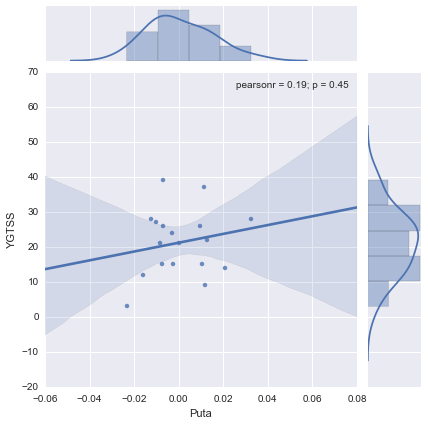

In [38]:
#drop = ['CB4P', 'NL2P', 'YU1P', 'LA9P','SA5U']
drop = drop_p # +  ['SA5U'] 
measure_1 = 'Puta'
measure_2 = 'YGTSS'
sns.jointplot(Xpatients_a[measure_1].drop(drop, axis = 0), Xpatients_a[measure_2].drop(drop, axis = 0), kind = 'reg')
#sns.jointplot(Xcontrols_a.Ferritin, Xcontrols_a.R_STN, kind = 'reg')

#plt.savefig('/Users/kanaan/Desktop/YGTSS_R_Ins.png')

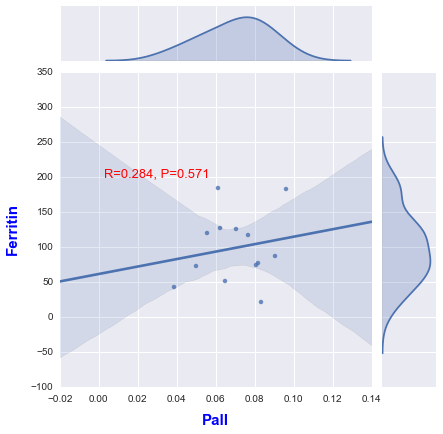

In [39]:
plot_partial_correlation(Xpatients_a.drop(drop, axis = 0), 'Pall', 'Ferritin',  regressors =['Age'] , 
                         color = None, annotate = (0.0025, 200), fig_name = None, 
                         dpi = 100, labels = True, jitter = None)

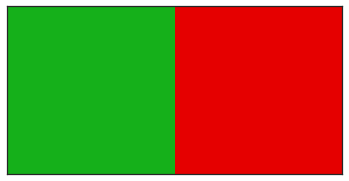

In [40]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

plt.rcParams['font.family'] = 'Myriad Pro'
p = sns.palplot(sns.xkcd_palette(['green', "red"]), size = 3)

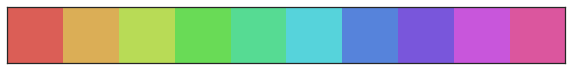

In [41]:
sns.palplot(sns.color_palette("hls",10 ))

[]

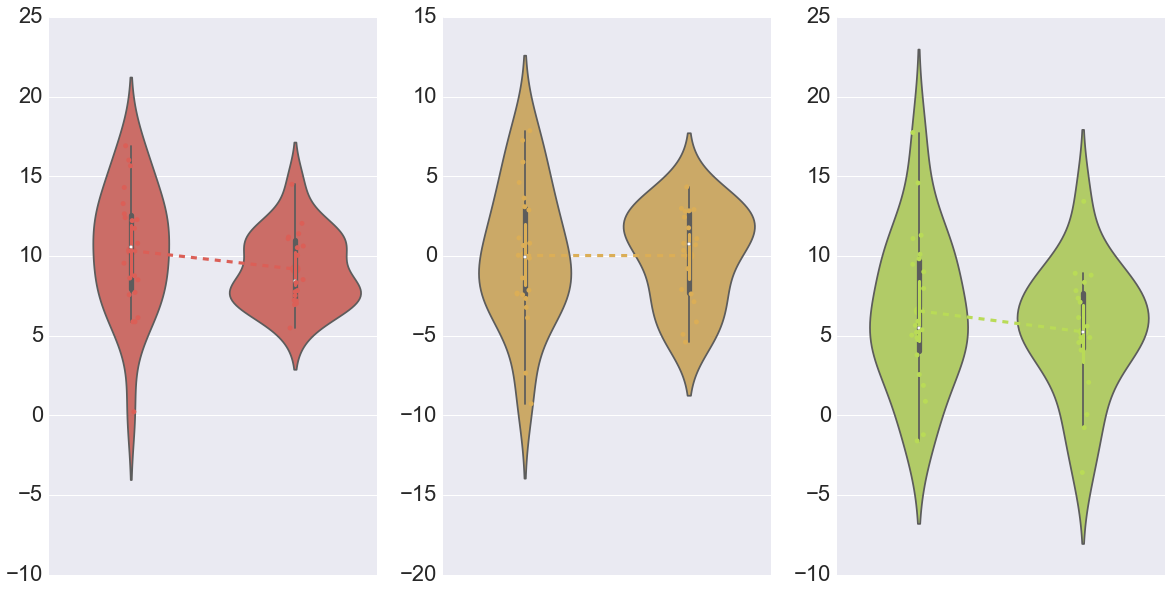

In [42]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p + ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'SN' 
measure_2 = 'STN'
measure_3 = 'RN'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(0, 23)
#ax2.set_ylim(-10, 18) 
#ax3.set_ylim(-10, 30)

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

#f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_1.png'), dpi = 600, bbox_inches='tight', transparent = False)

[]

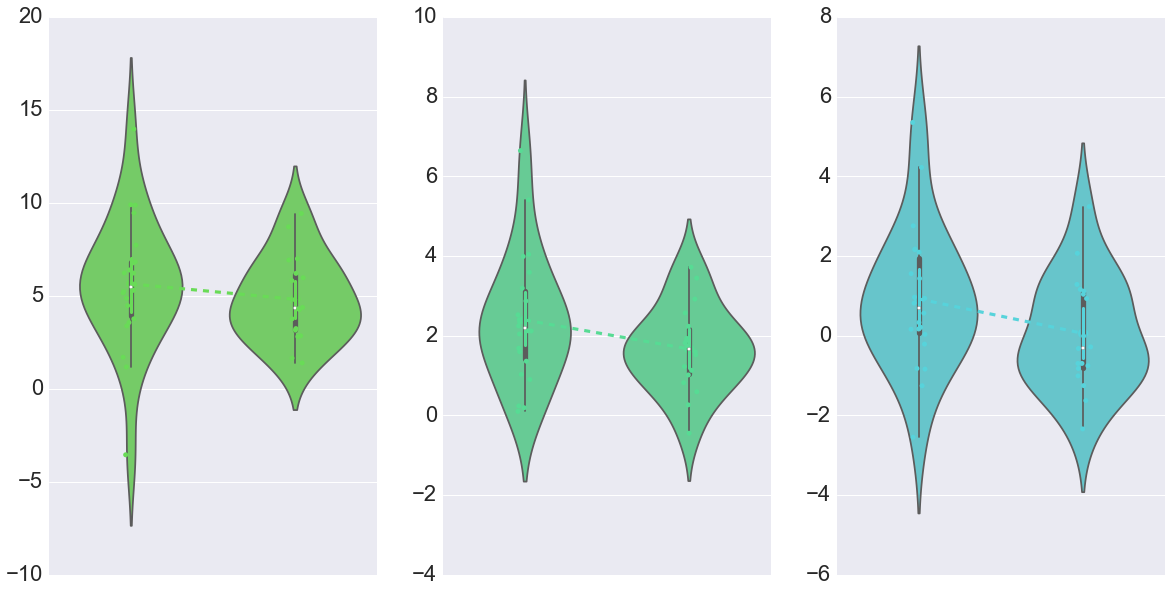

In [43]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p + ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'BrainStem' 
measure_2 = 'Caud'
measure_3 = 'Puta'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)[3:6]

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(-5, 22)
#ax2.set_ylim(-5, 10)
#ax3.set_ylim(-5, 8)


ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

#f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_2.png'), dpi = 600, bbox_inches='tight', transparent = False)

[]

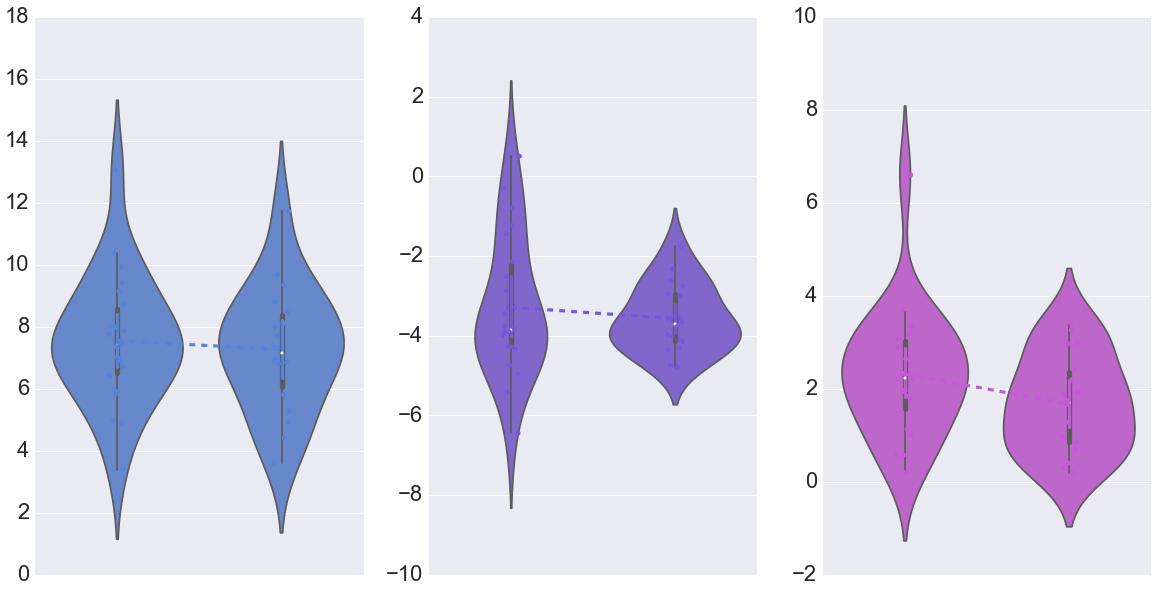

In [44]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p + ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'Pall' 
measure_2 = 'Thal'
measure_3 = 'BasalGanglia'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)[6:9]

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(1, 16)
#ax2.set_ylim(-9, 9)
#ax3.set_ylim(-2, 8)

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

#f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_3.png'), dpi = 600, bbox_inches='tight', transparent = False)